# Input Data Inspector Demo

This notebook demonstrates the `intccms.metrics.inspector` module for characterizing input ROOT files.

The inspector allows you to:
- Extract metadata from ROOT files (events, file sizes, branch sizes, compression ratios)
- Run distributed inspection using Dask
- Aggregate statistics across datasets
- Create visualizations of input data characteristics

**Works directly with DatasetManager**

In [1]:
import copy
import sys
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root/"example_cms"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")


from dask.distributed import Client, PipInstall
import matplotlib.pyplot as plt

import cloudpickle
import intccms
import example_cms

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)

from intccms.datasets import DatasetManager
from intccms.metrics.inspector import (
    extract_files_from_dataset_manager,
    get_dataset_file_counts,
    inspect_dataset_distributed,
    aggregate_statistics,
    group_by_dataset,
    compute_dataset_statistics,
    compute_compression_stats,
    format_error_summary,
    plot,
)

✅ Added /home/cms-jovyan/integration-challenge/cms/src to Python path
✅ Added /home/cms-jovyan/integration-challenge/cms/example_cms to Python path


In [2]:
def acquire_client():
    client = Client("tls://localhost:8786")
    #dependencies = ["rucio"] #["coffea==2025.10.2"]
    #client.register_plugin(PipInstall(packages=dependencies))
    cluster = None  # no local cluster in this mode
    return client, cluster

## Step 1: Load Dataset Configuration

Load the dataset configuration from `example_cms/configs/skim.py`.
This uses the same configuration as your processing workflow.

In [3]:
from example_cms.configs.configuration import config as original_config
from intccms.schema import Config, load_config_with_restricted_cli
# Configuration setup
config = copy.deepcopy(original_config)

cli_args = []
full_config = load_config_with_restricted_cli(config, cli_args)
validated_config = Config(**full_config)

# Create DatasetManager
dm = DatasetManager(validated_config.datasets)

print("Available datasets:")
for name in dm.datasets.keys():
    print(f"  - {name}")

Available datasets:
  - signal
  - ttbar_semilep
  - ttbar_had
  - ttbar_lep
  - wjets
  - dyjets
  - single_top
  - qcd
  - diboson
  - data


## Step 2: Quick File Count Summary

Get a quick count of files per dataset without full inspection.

In [4]:
file_counts = get_dataset_file_counts(dm)

print("\nFile counts per dataset:")
for dataset, count in file_counts.items():
    print(f"  {dataset}: {count} files")


File counts per dataset:
  signal: 26 files
  ttbar_semilep: 826 files
  ttbar_had: 684 files
  ttbar_lep: 303 files
  wjets: 7989 files
  dyjets: 529 files
  single_top: 792 files
  qcd: 1150 files
  diboson: 165 files
  data: 1057 files


## Step 3: Extract Files for Inspection

Extract file paths from DatasetManager. You can:
- Inspect all datasets
- Inspect specific processes
- Limit files per process (useful for quick sampling)

In [5]:
# Option A: Sample first 5 files per dataset for quick testing
# file_list, dataset_map = extract_files_from_dataset_manager(
#     dm,
#     max_files_per_process=5,
# )

# Option B: Inspect specific datasets
# file_list, dataset_map = extract_files_from_dataset_manager(
#     dm,
#     processes=["signal", "ttbar_semilep"],
#     max_files_per_process=10,
# )

# Option C: Inspect all files (can be slow for large datasets!)
file_list, dataset_map = extract_files_from_dataset_manager(dm)

print(f"\nExtracted {len(file_list)} files for inspection")
print(f"Example file: {file_list[0]}")


Extracted 13521 files for inspection
Example file: root://xcache//store/mc/RunIISummer20UL16NanoAODv9/ZPrimeToTT_M2000_W200_TuneCP2_13TeV-madgraph-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/270000/7A83E108-8CB7-5647-8848-C2C48F430E09.root


## Step 4: Distributed Inspection with Dask

Run distributed file inspection using Dask.
This extracts metadata from all files in parallel.

In [6]:
try:
    # Start a local Dask cluster
    client, _ = acquire_client()
    print(f"Dask dashboard: {client.dashboard_link}")
    # Run distributed inspection
    # Note: max_branches limits the number of branches inspected per file for faster results
    results, errors = inspect_dataset_distributed(
        client,
        file_list,
        max_branches=500,  # Limit to first 100 branches for speed
    )
    
    # Print formatted error summary
    print(format_error_summary(errors))
    
    if results:
        print(f"\n=== Example Result ===")
        print(f"  File: {results[0]['filepath']}")
        print(f"  Events: {results[0]['num_events']:,}")
        print(f"  Branches: {results[0]['num_branches']}")
    else:
        print("\nNo files were successfully inspected!")
        
finally:
    client.close()
    

Dask dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status
=== Inspection Summary ===
Total files:   13521
Successful:    13520
Failed:           1
Success rate: 100.0%

=== Failures ===
File                                                                                                                                                                                                                       Error Type          Error Message  
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
root://xcache//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/6D89A04A-16DE-394A-8DBF-01BD223D5795.root  DecompressionError  lzma data error

=== Example Result ===
  File: root://xcache//

## Step 5: Aggregate Statistics

Compute aggregate statistics across all inspected files.

### Optional: Fetch File Sizes from Rucio

Use the inspector's Rucio helper to retrieve authoritative file sizes. This
requires a valid Rucio environment (credentials and network access). If the
lookup fails, the notebook continues with locally derived statistics.

In [21]:
from intccms.metrics.inspector import rucio as inspector_rucio
from rich.console import Console

size_summary = None
try:
    size_summary = inspector_rucio.fetch_file_sizes(
        dm,
        processes=["signal", "ttbar_semilep"],
        max_files_per_process=5,
    )
    console = Console(force_jupyter=False)
    console.print(inspector_rucio.format_dataset_size_table(size_summary))
except Exception as exc:
    print("Skipping Rucio size lookup (set size_summary=None):", exc)
    size_summary = None

Failed to fetch size for /store/mc/RunIISummer20UL16NanoAODv9/ZPrimeToTT_M2000_W200_TuneCP2_13TeV-madgraph-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/270000/7A83E108-8CB7-5647-8848-C2C48F430E09.root: 'Client' object has no attribute 'get_file_meta'
Failed to fetch size for /store/mc/RunIISummer20UL16NanoAODv9/ZPrimeToTT_M2000_W200_TuneCP2_13TeV-madgraph-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2530000/288B512F-09A1-5D48-8D1B-6216C5904FB5.root: 'Client' object has no attribute 'get_file_meta'
Failed to fetch size for /store/mc/RunIISummer20UL17NanoAODv9/ZPrimeToTT_M2000_W200_TuneCP2_13TeV-madgraph-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v2/2530000/C2D4872A-02B9-FC45-BC31-C2C1D0411914.root: 'Client' object has no attribute 'get_file_meta'
Failed to fetch size for /store/mc/RunIISummer20UL17NanoAODv9/ZPrimeToTT_M2000_W200_TuneCP2_13TeV-madgraph-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v2/260000/1136DC3D-FB53-BA49-AA82-0AEA26CB12E3.root: 'Client' object has no attribut

                  Dataset File Sizes                  
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Dataset       ┃ Files ┃ Total Size ┃ Avg Size/File ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ signal        │     5 │        0 B │           0 B │
│ ttbar_semilep │     5 │        0 B │           0 B │
│ TOTAL         │    10 │        0 B │               │
└───────────────┴───────┴────────────┴───────────────┘


In [22]:
from rich.console import Console
from intccms.metrics.inspector import (
    format_overall_stats_table,
    format_branch_stats_table,
    format_dataset_stats_table,
    format_compression_stats_table,
)

# Create console
console = Console(force_jupyter=False)

# Aggregate and display statistics
stats = aggregate_statistics(results, size_summary=None)
table = format_overall_stats_table(stats)
console.print(table)

            Overall Statistics            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                 ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Total Files            │        13,520 │
│ Total Events           │ 6,829,521,103 │
│ Total Size             │       0.00 GB │
├────────────────────────┼───────────────┤
│ Avg Events/File        │       505,142 │
│ Median Events/File     │       153,154 │
│ P90 Events/File        │     1,346,000 │
├────────────────────────┼───────────────┤
│ Avg File Size          │       0.00 GB │
│ Median File Size       │       0.00 GB │
├────────────────────────┼───────────────┤
│ Avg Bytes/Event        │           0 B │
│ Avg Bytes/Event/Branch │           0 B │
├────────────────────────┼───────────────┤
│ Total Branches         │           611 │
└────────────────────────┴───────────────┘


## Step 6: Branch statistics

Analyze branch size and compression distributions.

In [9]:
from intccms.metrics.inspector.aggregator import compute_branch_statistics

branch_stats = compute_branch_statistics(results)

table = format_branch_stats_table(branch_stats)
console.print(table)

        Branch Statistics         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric             ┃     Value ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Number of Branches │       611 │
├────────────────────┼───────────┤
│ Median Branch Size │  40.22 MB │
│ Mean Branch Size   │  42.63 MB │
│ Max Branch Size    │ 203.33 MB │
├────────────────────┼───────────┤
│ Median Compression │     4.79x │
│ Mean Compression   │    10.94x │
└────────────────────┴───────────┘


## Step 7: Per-Dataset Statistics

Group results by dataset and compute per-dataset statistics.

In [10]:
# Group by dataset
grouped = group_by_dataset(results, dataset_map)

# Compute per-dataset statistics
dataset_stats = compute_dataset_statistics(grouped)

# Display as rich table
table = format_dataset_stats_table(dataset_stats)
console.print(table)

                             Per-Dataset Statistics                             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃               ┃       ┃        ┃        ┃        ┃    Avg ┃        ┃         ┃
┃               ┃       ┃  Total ┃    Avg ┃  Total ┃   File ┃        ┃         ┃
┃ Dataset       ┃ Files ┃ Events ┃ Event… ┃   Size ┃   Size ┃ Bytes… ┃ Bytes/… ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ signal        │    26 │ 1,230… │ 47,308 │   0.00 │   0.00 │    0 B │     0 B │
│               │       │        │        │     GB │     GB │        │         │
│ ttbar_semilep │   826 │ 967,1… │ 1,170… │   0.00 │   0.00 │    0 B │     0 B │
│               │       │        │        │     GB │     GB │        │         │
│ ttbar_had     │   684 │ 674,2… │ 985,7… │   0.00 │   0.00 │    0 B │     0 B │
│               │       │        │        │     GB │     GB │        │         │
│ ttbar_lep     │   303 │ 29

## Step 8: Compression Statistics

Analyze compression ratios across all files.

In [11]:
compression_stats = compute_compression_stats(results)
# Display as rich table
table = format_compression_stats_table(compression_stats)
console.print(table)

         Compression Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Metric                  ┃       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Files with Compression  │      13,520 │
├─────────────────────────┼─────────────┤
│ Avg Tree Compression    │       4.45x │
│ Median Tree Compression │       4.39x │
│ Overall Compression     │       4.63x │
├─────────────────────────┼─────────────┤
│ Total Compressed        │  9943.27 GB │
│ Total Uncompressed      │ 46045.70 GB │
│ Space Savings           │ 36102.43 GB │
└─────────────────────────┴─────────────┘


## Step 9: Visualizations

Create plots to visualize the inspection results.

# Events per file ratio by dataset

### Events per file ratio by dataset

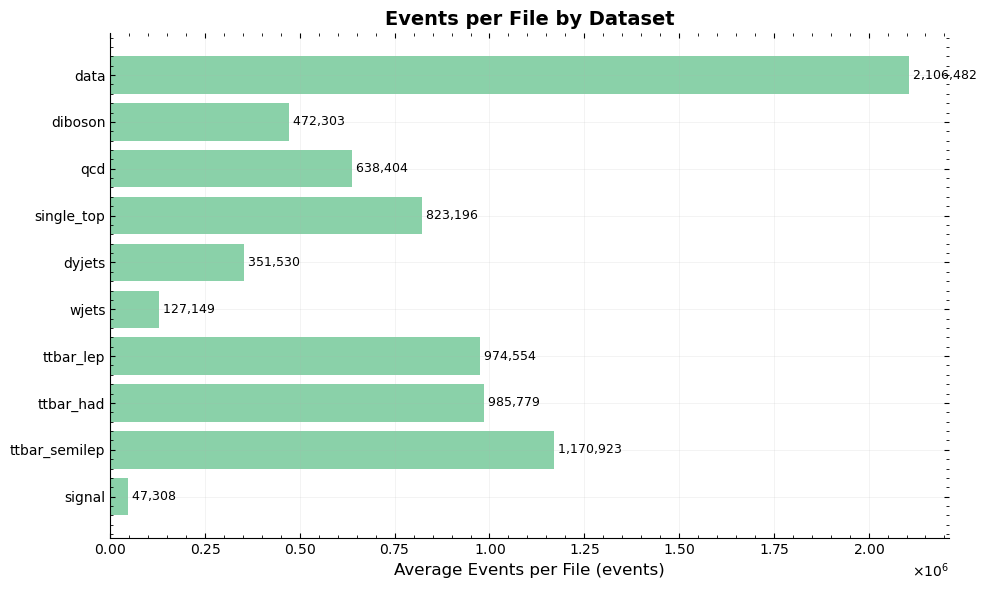

In [12]:
fig, ax = plot.plot_events_per_file_by_dataset(dataset_stats)
plt.show()

### Event Distribution

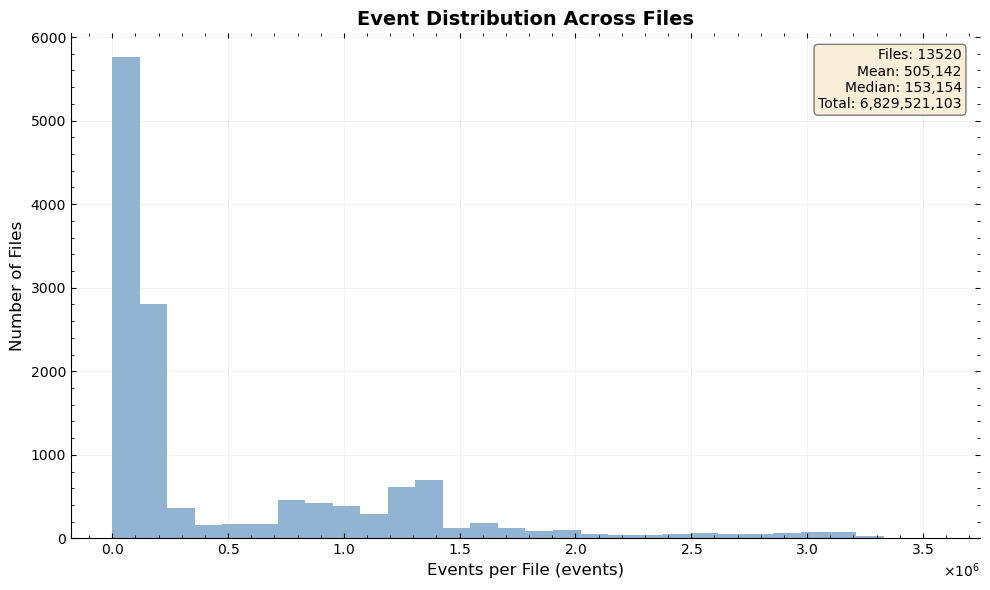

In [13]:
fig, ax = plot.plot_event_distribution(results)
plt.show()

### Dataset Comparison

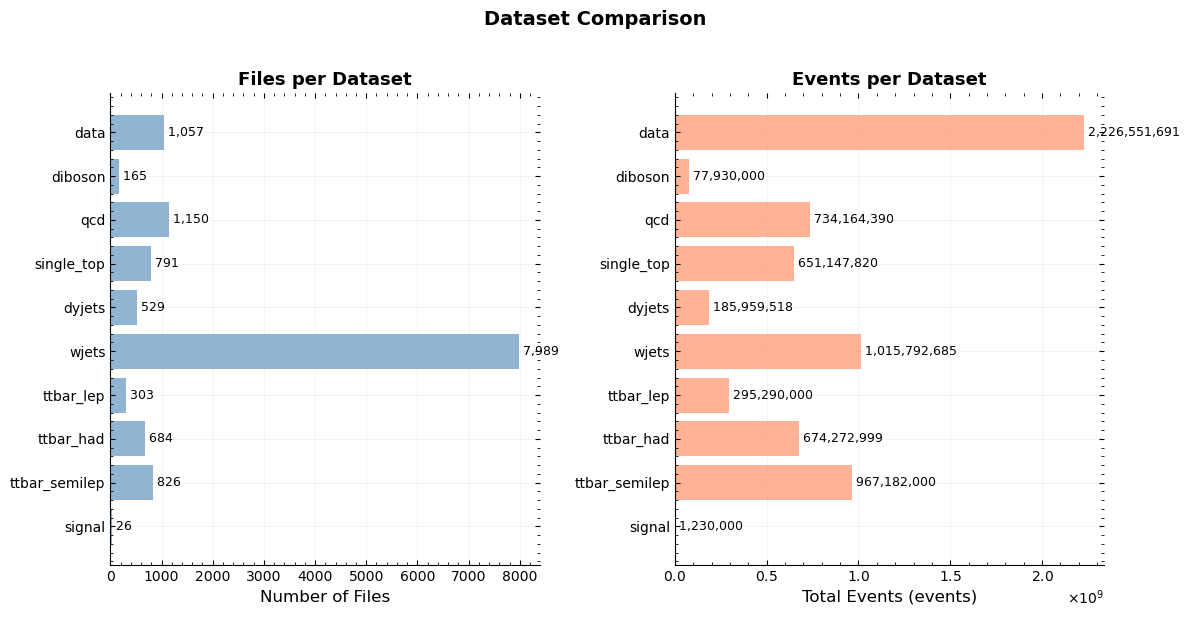

In [14]:
fig, (ax1, ax2) = plot.plot_dataset_comparison(dataset_stats)
plt.show()

### Understanding Box Plots

The box plots in this analysis show statistical distributions:

- **Box**: Contains the middle 50% of data (interquartile range, IQR)
- **Line inside box**: Median value (50th percentile)
- **Whiskers**: Extend to the 5th and 95th percentiles
- **Points beyond whiskers**: Outliers outside the 5th-95th percentile range

This visualization helps identify data skewness, outliers, and distribution characteristics.


### Branch Size Distribution

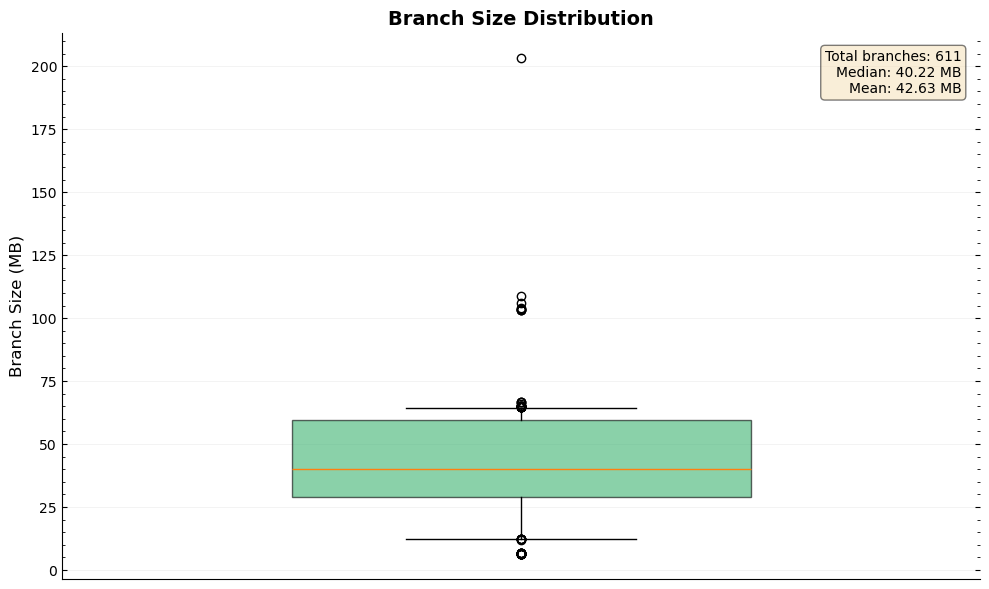

In [15]:
fig, ax = plot.plot_branch_size_distribution(results)
plt.show()

### Branch Compression Distribution

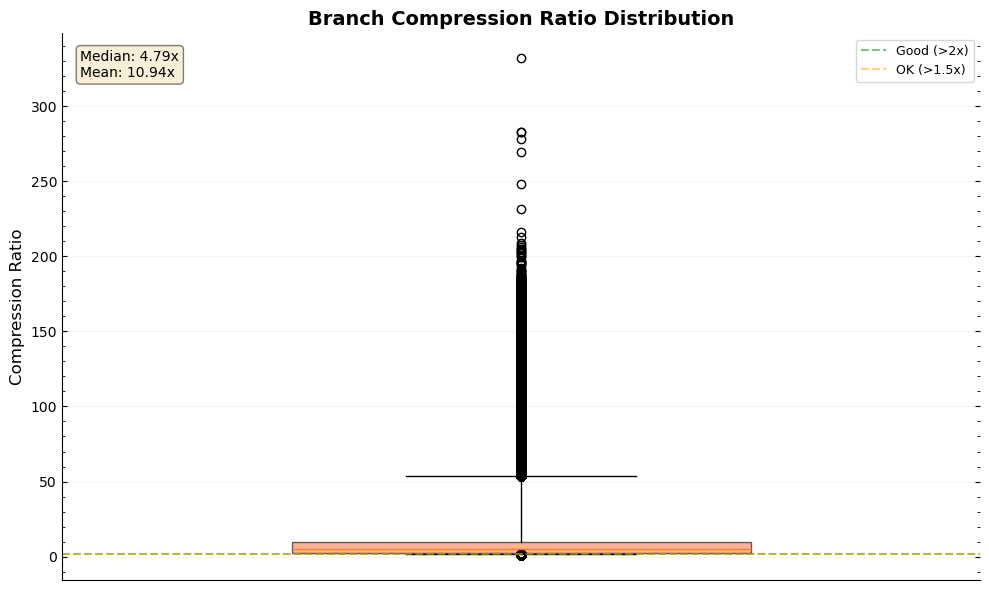

In [16]:
fig, ax = plot.plot_branch_compression_distribution(results)
if fig is not None:
    plt.show()
else:
    print("No compression data available")

### Branch Distributions by Dataset

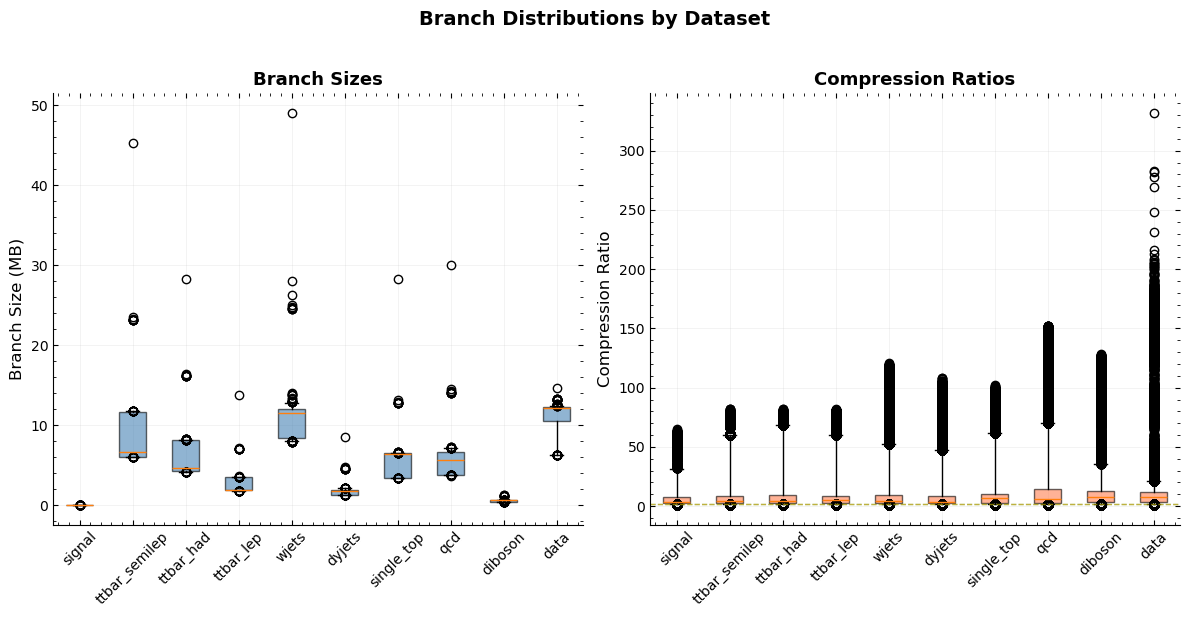

In [17]:
fig, (ax1, ax2) = plot.plot_branch_distributions_by_dataset(results, dataset_map)
plt.show()

### File Size Distribution

In [18]:
fig, ax = plot.plot_file_size_distribution(results)
if fig is not None:
    plt.show()
else:
    print("No file size data available (all files are remote)")

No file size data available (all files are remote)
No file size data available (all files are remote)


### Summary Dashboard

Create a comprehensive dashboard with all key plots.

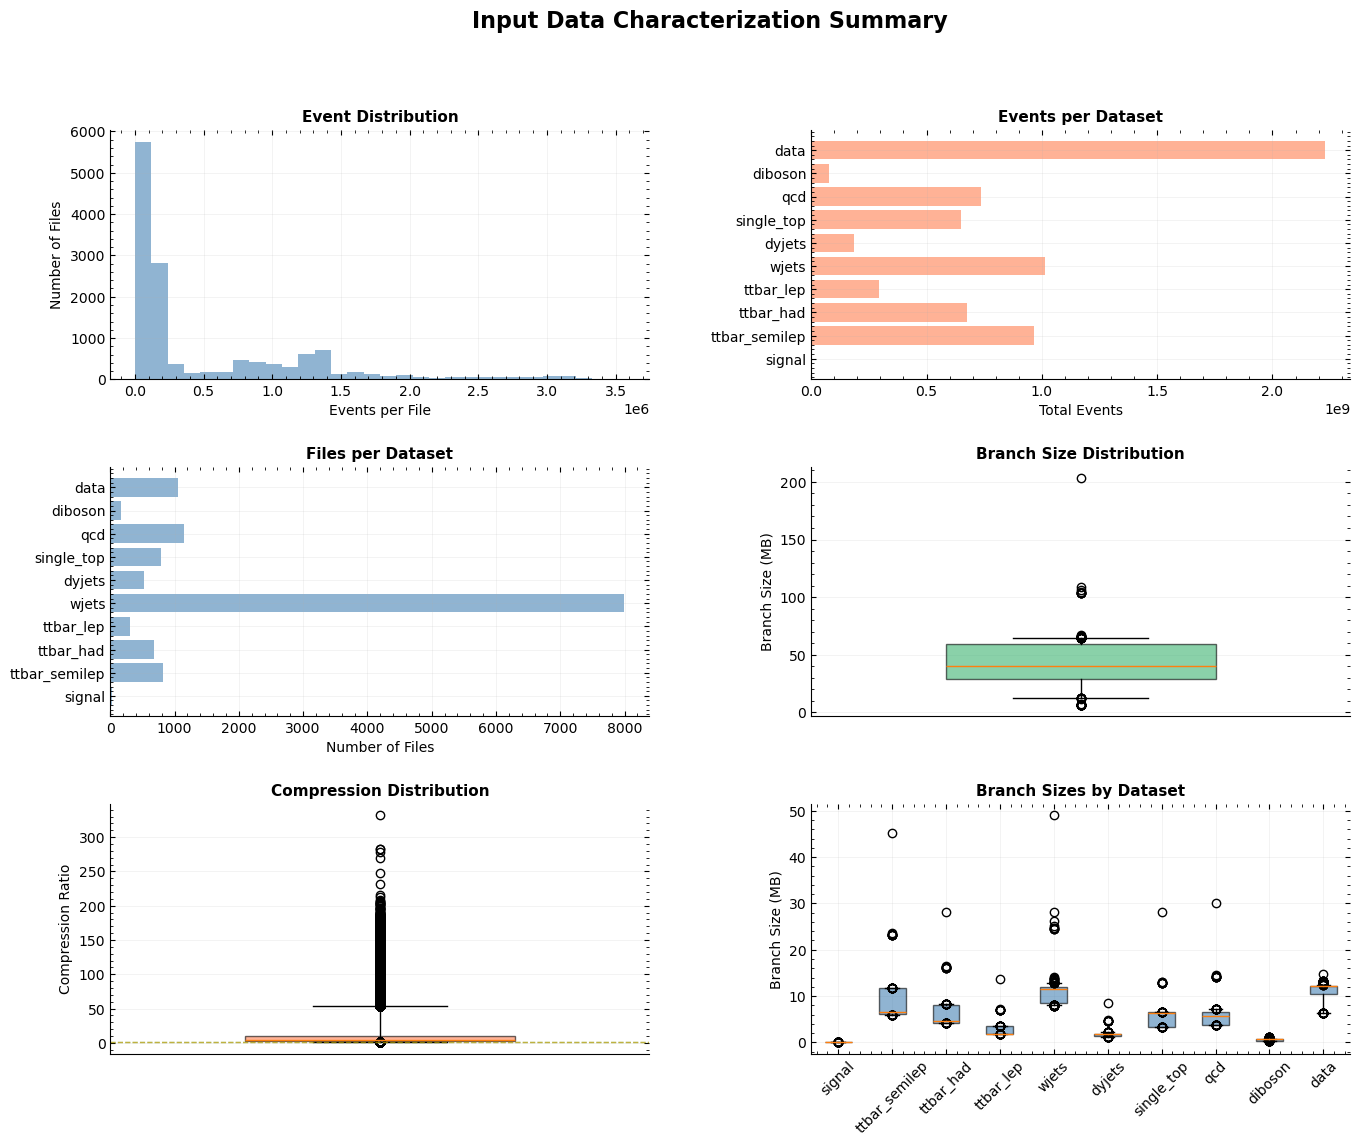

In [19]:
fig = plot.plot_summary_dashboard(results, dataset_stats, dataset_map)
plt.show()

## Step 10: Save Results

You can save plots to files and export statistics to JSON.

In [20]:
import json

# Save summary dashboard
# fig = plot.plot_summary_dashboard(
#     results, dataset_stats, top_branches,
#     save_path="input_summary.png"
# )

# Export statistics to JSON
# output = {
#     "overall_stats": stats,
#     "dataset_stats": dataset_stats,
#     "compression_stats": compression_stats,
#     "top_branches": [
#         {"name": name, "size_bytes": size, "compression_ratio": ratio}
#         for name, size, ratio in top_branches
#     ],
# }
# 
# with open("inspection_results.json", "w") as f:
#     json.dump(output, f, indent=2)

print("Done! You can save plots and export statistics as needed.")

Done! You can save plots and export statistics as needed.
